In [1]:
%matplotlib inline

## This notebook demonstrates cool augmentation examples on diverse set of images from various real-world tasks.

In [2]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_idx_to_name, color=BOX_COLOR, thickness=2):
    height, width = img.shape[:2]
    bbox = A.denormalize_bbox(bbox, height, width)
    x_min, y_min, x_max, y_max, class_idx = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_idx]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35, TEXT_COLOR,
                lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, mask, bboxes=[], category_id_to_name=[]):
    augmented = aug(image=image, mask=mask, bboxes=bboxes)
    f, ax = plt.subplots(2, 2, figsize=(16, 16))

    for bbox in bboxes:
        visualize_bbox(image, bbox, category_id_to_name)

    for bbox in augmented['bboxes']:
        augmented['bboxes'] = A.filter_bboxes_by_visibility(image, bboxes, augmented['image'], augmented['bboxes'], 0.5)
        visualize_bbox(augmented['image'], bbox, category_id_to_name)

    ax[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0, 0].set_title('Original image')

    ax[1, 0].imshow(label2rgb(mask, bg_label=0), interpolation='nearest')
    ax[1, 0].set_title('Original mask')

    ax[0, 1].imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))
    ax[0, 1].set_title('Augmented image')

    ax[1, 1].imshow(label2rgb(augmented['mask'], bg_label=0), interpolation='nearest')
    ax[1, 1].set_title('Augmented mask')
    f.tight_layout()
    
    return augmented['image'], augmented['mask'], augmented['bboxes']

def find_in_dir(dirname):
    return [os.path.join(dirname, fname) for fname in sorted(os.listdir(dirname))]


# Inria Aerial Image Labeling Dataset

# Mapilary Vistas

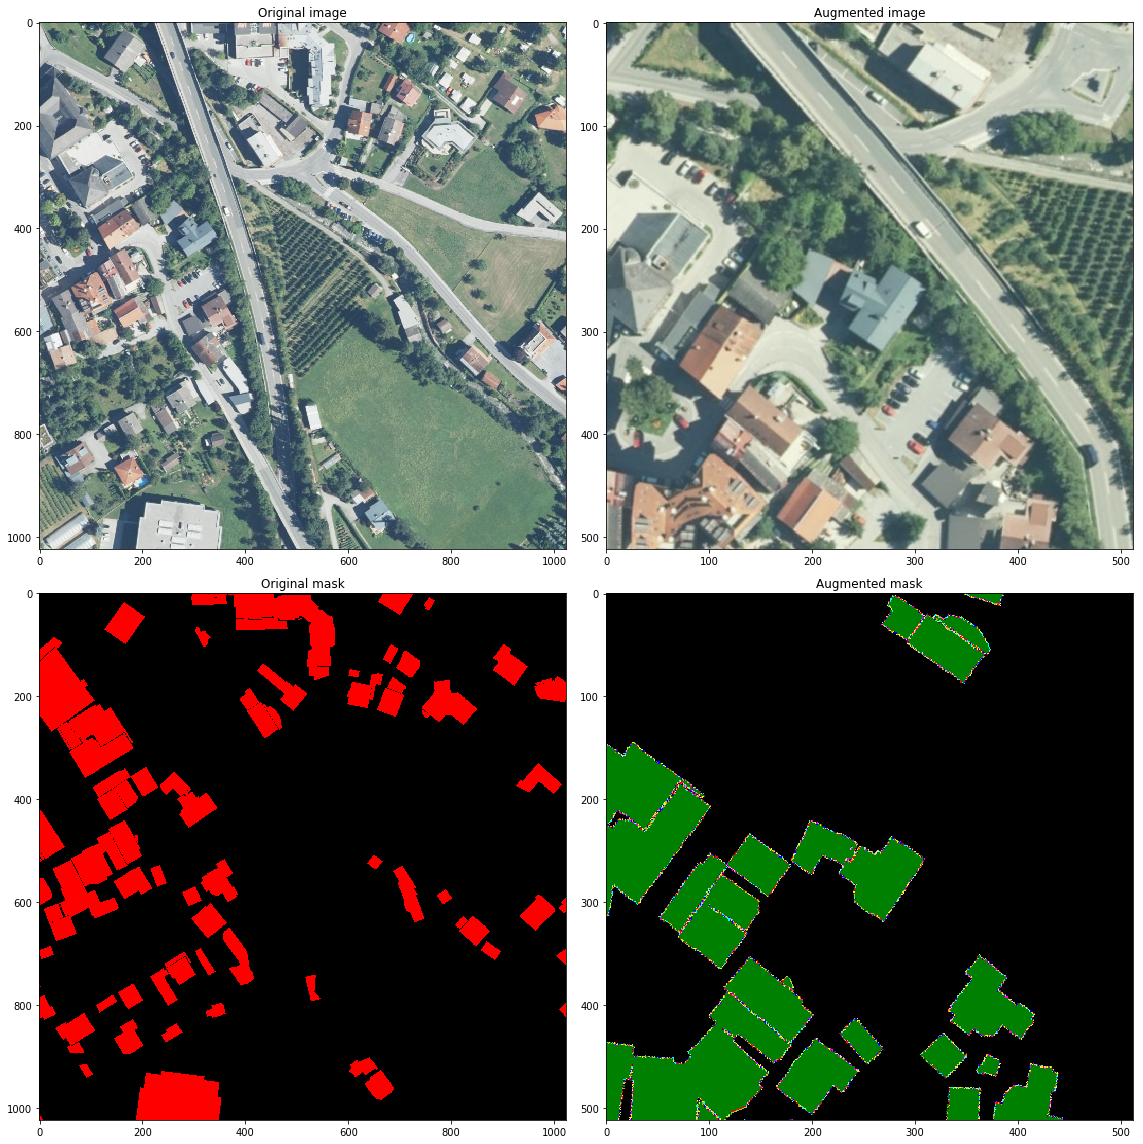

In [3]:
random.seed(42)

image, mask = cv2.imread('images/inria/inria_tyrol_w4_image.jpg'), cv2.imread('images/inria/inria_tyrol_w4_mask.tif', cv2.IMREAD_GRAYSCALE)
image, mask = image[:1024, :1024], mask[:1024,:1024]

aug = A.Compose([
    A.RandomSizedCrop((512-100, 512+100), 512, 512),
    A.ShiftScaleRotate(),
    A.RGBShift(),
    A.Blur(),
    A.GaussNoise(),
],p=1)

r = augment_and_show(aug, image, mask)

# 2018 Data Science Bowl

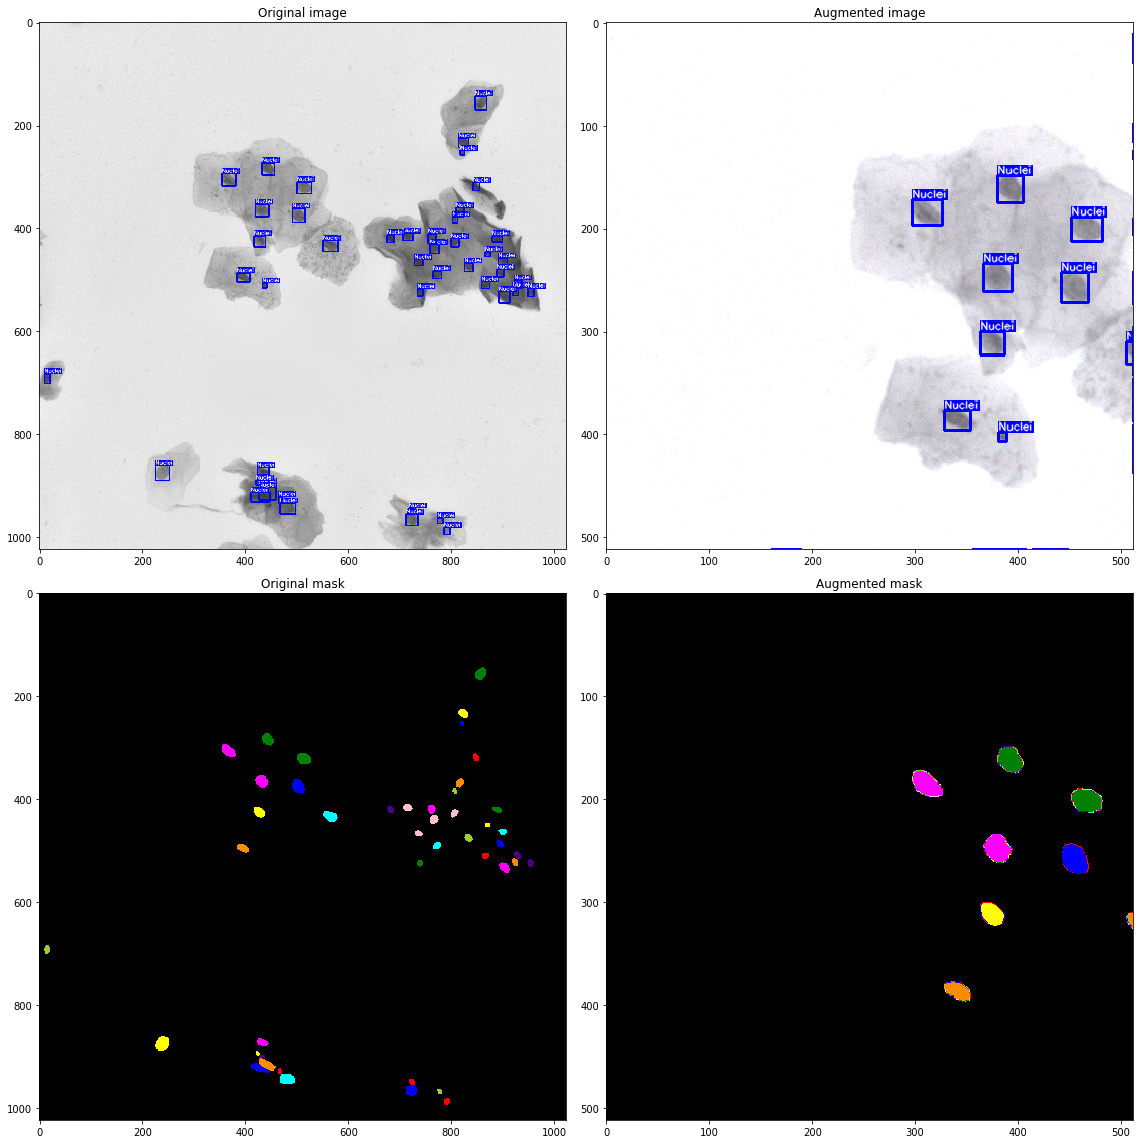

In [4]:
random.seed(42)

image = cv2.imread(
    'images/dsb2018/1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e/images/1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e.png')
masks = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in
         find_in_dir('images/dsb2018/1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e/masks')]
bboxes = [cv2.boundingRect(cv2.findNonZero(mask)) for mask in masks]
label_image = np.zeros_like(masks[0])
for i, mask in enumerate(masks):
    label_image += (mask > 0).astype(np.uint8) * i

aug = A.Compose([
    A.RandomSizedCrop((512 - 100, 512 + 100), 512, 512),
    A.RGBShift(),
    A.Blur(),
    A.GaussNoise(),
    A.Flip(),
    A.RandomRotate90()
], p=1)

label_names = ['Nuclei']
coco_bboxes = [list(bbox) + [0] for bbox in bboxes]
coco_bboxes = A.convert_bboxes_to_albumentations(image.shape, coco_bboxes, source_format='coco')

r = augment_and_show(aug, image, label_image, coco_bboxes, label_names)


# Mapilary Vistas

# Mapilary Vistas

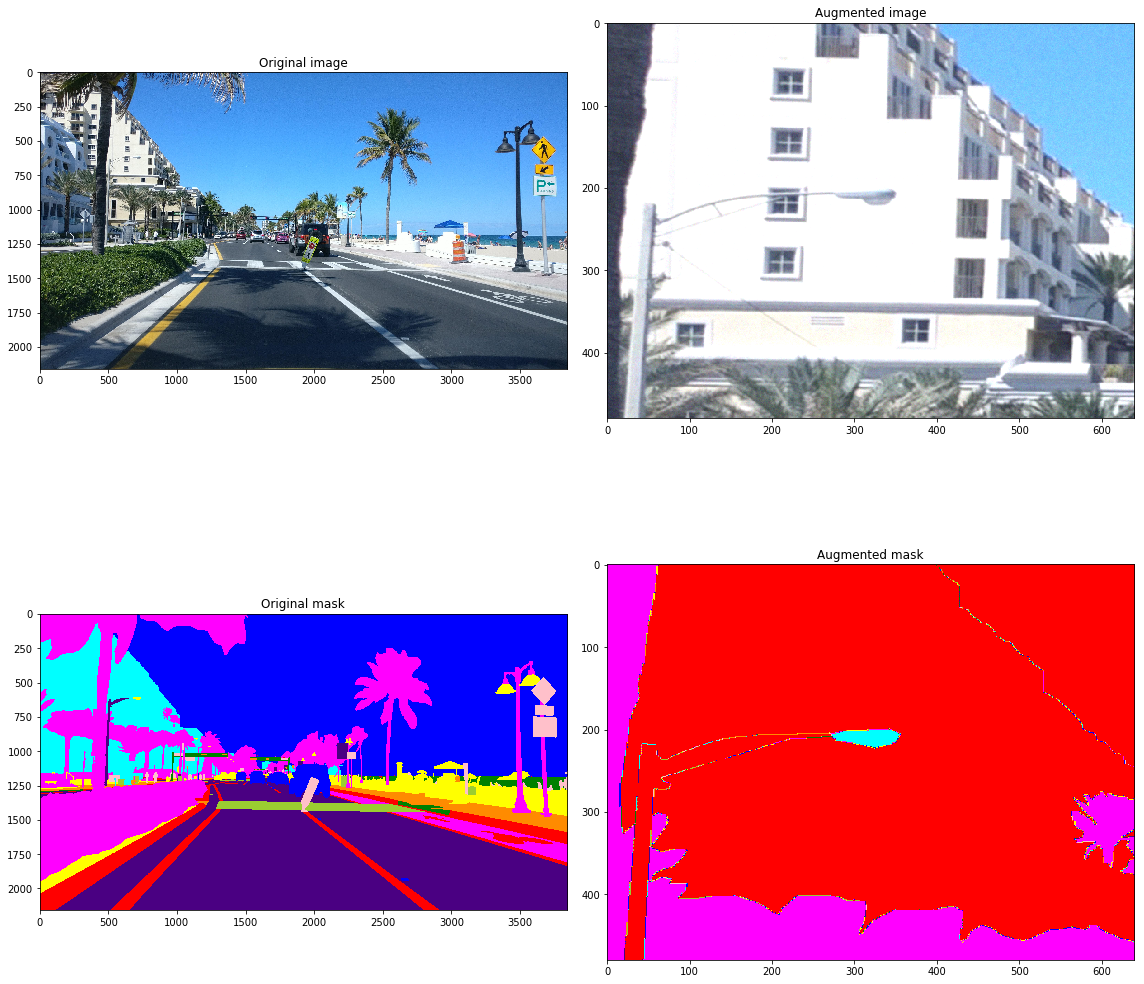

In [5]:
from PIL import Image

random.seed(42)

image = cv2.imread('images/vistas/aSqVUgt36gddhmJdI1lXNA.jpg')
mask = np.array(Image.open('images/vistas/aSqVUgt36gddhmJdI1lXNA.png'))

# bboxes = [cv2.boundingRect(cv2.findNonZero(mask)) for mask in masks]
# label_image = np.zeros_like(masks[0])
# for i, mask in enumerate(masks):
#     label_image += (mask > 0).astype(np.uint8) * i

aug = A.Compose([
    A.RandomSizedCrop((512 - 100, 512 + 100), 480, 640),
    A.RGBShift(),
    A.Blur(),
    A.GaussNoise(),
    A.HorizontalFlip()
], p=1)

r = augment_and_show(aug, image, mask)


